# CS224N Assignment 1: Exploring Word Vectors (25 Points)
### <font color='blue'> Due 4:30pm, Tue January 14th 2025</font>

Welcome to CS224N!

Before you start, make sure you **read the README.md** in the same directory as this notebook for important setup information. You need to install some Python libraries before you can successfully do this assignment. A lot of code is provided in this notebook, and we highly encourage you to read and understand it as part of the learning :)

If you aren't super familiar with Python, Numpy, or Matplotlib, we recommend you check out the review session on Friday. The session will be recorded and the material will be made available on our [website](http://web.stanford.edu/class/cs224n/index.html#schedule). The CS231N Python/Numpy [tutorial](https://cs231n.github.io/python-numpy-tutorial/) is also a great resource.


**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

In [37]:
!pip install gensim

In [38]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0] == 3
assert sys.version_info[1] >= 8

from platform import python_version
assert int(python_version().split(".")[1]) >= 5, "Please upgrade your Python version following the instructions in \
    the README.md file found in the same directory as this notebook. Your Python version is " + python_version()

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

from datasets import load_dataset
imdb_dataset = load_dataset("stanfordnlp/imdb", name="plain_text")

import re
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'
NUM_SAMPLES = 150

np.random.seed(0)
random.seed(0)
# ----------------

## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*.

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](https://web.stanford.edu/~jurafsky/slp3/6.pdf) or [here](https://web.archive.org/web/20190530091127/https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

In NLP, we commonly use `<START>` and `<END>` tokens to mark the beginning and end of sentences, paragraphs, or documents. These tokens are included in co-occurrence counts, encapsulating each document, for example: "`<START>` All that glitters is not gold `<END>`".

The matrix rows (or columns) provide word vectors based on word-word co-occurrence, but they can be large. To reduce dimensionality, we employ Singular Value Decomposition (SVD), akin to PCA, selecting the top $k$ principal components. The SVD process decomposes the co-occurrence matrix $A$ into singular values in the diagonal $S$ matrix and new, shorter word vectors in $U_k$.

This dimensionality reduction maintains semantic relationships; for instance, *doctor* and *hospital* will be closer than *doctor* and *dog*.

For those unfamiliar with eigenvalues and SVD, a beginner-friendly introduction to SVD is available [here](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). Additional resources for in-depth understanding include lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168, providing high-level treatment of these algorithms. For practical implementation, utilizing pre-programmed functions from Python packages like numpy, scipy, or sklearn is recommended. While applying full SVD to large corpora can be memory-intensive, scalable techniques such as Truncated SVD exist for extracting the top $k$ vector components efficiently.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. We provide a `read_corpus` function below that pulls out the text of a movie review from the dataset. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [39]:
print(imdb_dataset['train'][0])


{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [40]:
for i in range(5):
    print(imdb_dataset['train'][i])
    print("---")


{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [41]:
# Посмотреть уникальные метки
print(imdb_dataset['train'].unique('label'))

# Посчитать количество примеров каждой метки
from collections import Counter
labels = [x['label'] for x in imdb_dataset['train']]
print(Counter(labels))


[0, 1]
Counter({0: 12500, 1: 12500})


In [42]:
import pandas as pd

train_df = pd.DataFrame(imdb_dataset['train'])
print(train_df['label'].value_counts())


label
0    12500
1    12500
Name: count, dtype: int64


In [43]:
def read_corpus():
    """ Read files from the Large Movie Review Dataset.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = imdb_dataset["train"]["text"][:NUM_SAMPLES]
    return [[START_TOKEN] + [re.sub(r'[^\w]', '', w.lower()) for w in f.split(" ")] + [END_TOKEN] for f in files]

In [44]:
w = "Hello, World!"
clean_w = re.sub(r'[^\w]', '', w.lower())
print(clean_w)

helloworld


Let's have a look what these documents are like….

In [45]:
imdb_corpus = read_corpus()
pprint.pprint(imdb_corpus[:3], compact=True, width=100)
print("corpus size: ", len(imdb_corpus[0]))

[['<START>', 'i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because',
  'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first',
  'released', 'in', '1967', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized',
  'by', 'us', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', 'therefore',
  'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to',
  'see', 'this', 'for', 'myselfbr', 'br', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young',
  'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything',
  'she', 'can', 'about', 'life', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her',
  'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average',
  'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam',
  'war', 'and', 'race', 'issu

### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus.

You can use `for` loops to process the input `corpus` (a list of list of strings), but try using Python list comprehensions (which are generally faster). In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned `corpus_words` should be sorted. You can use python's `sorted` function for this.

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [46]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    n_corpus_words = -1
    word_to_index = []
    # ------------------
    # 1. Собираем все слова из корпуса в один список
    all_words = [word for sentence in corpus for word in sentence]

    print(all_words)

    # 2. Убираем дубликаты с помощью set и сортируем слова
    corpus_words = sorted(set(all_words))

    print(corpus_words)

    # 3. Подсчитываем количество уникальных слов
    n_corpus_words = len(corpus_words)
    # ------------------
    print(n_corpus_words)


    # 4. индекс (для себя)
    word_to_index = {word: idx for idx, word in enumerate(corpus_words)}
    print(f'words&indexs: {word_to_index}')

    return corpus_words, n_corpus_words

In [47]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)


['<START>', 'All', 'that', 'glitters', "isn't", 'gold', '<END>', '<START>', "All's", 'well', 'that', 'ends', 'well', '<END>']
['<END>', '<START>', 'All', "All's", 'ends', 'glitters', 'gold', "isn't", 'that', 'well']
10
words&indexs: {'<END>': 0, '<START>': 1, 'All': 2, "All's": 3, 'ends': 4, 'glitters': 5, 'gold': 6, "isn't": 7, 'that': 8, 'well': 9}
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/).


In [ ]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.

              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".

        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):
                Co-occurence matrix of word counts.
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, n_words = distinct_words(corpus)
    M = None
    word2ind = {}

    # ------------------
    # Write your implementation here.


    # ------------------

    return M, word2ind

In [48]:
import numpy as np

def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy array): symmetric co-occurrence matrix
            word2ind (dict): mapping word -> row/column index
    """
    # Получаем список уникальных слов и их количество
    words, n_words = distinct_words(corpus)

    # Создаем словарь: слово -> индекс
    word2ind = {word: i for i, word in enumerate(words)}

    # Инициализируем матрицу нулями
    M = np.zeros((n_words, n_words), dtype=np.int32)

    # Проходим по всем предложениям в корпусе
    for sentence in corpus:
        for center_idx, center_word in enumerate(sentence):
            center_word_idx = word2ind[center_word]

            # Определяем границы окна
            start = max(center_idx - window_size, 0)
            end = min(center_idx + window_size + 1, len(sentence))

            # Проходим по словам в окне
            for context_idx in range(start, end):
                if context_idx == center_idx:
                    continue  # не считаем само центральное слово
                context_word = sentence[context_idx]
                context_word_idx = word2ind[context_word]

                # Увеличиваем счетчик для пары слов
                M[center_word_idx, context_word_idx] += 1

    return M, word2ind


In [49]:
M_test

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 0, 0, 0, 1, 0]], dtype=int32)

In [50]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array(
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

['<START>', 'All', 'that', 'glitters', "isn't", 'gold', '<END>', '<START>', "All's", 'well', 'that', 'ends', 'well', '<END>']
['<END>', '<START>', 'All', "All's", 'ends', 'glitters', 'gold', "isn't", 'that', 'well']
10
words&indexs: {'<END>': 0, '<START>': 1, 'All': 2, "All's": 3, 'ends': 4, 'glitters': 5, 'gold': 6, "isn't": 7, 'that': 8, 'well': 9}
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings.

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [ ]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """
    n_iters = 10    # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    # ------------------
    # Write your implementation here.


    # ------------------

    print("Done.")
    return M_reduced

In [51]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix to k-dimensional embeddings using Truncated SVD. """
    n_iters = 10    # Количество итераций для SVD
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    # Создаем объект SVD
    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=0)

    # Подгоняем SVD и трансформируем матрицу
    # Метод fit_transform возвращает U * S
    M_reduced = svd.fit_transform(M)

    print("Done.")
    return M_reduced


In [52]:
import matplotlib.pyplot as plt

def plot_embeddings_2d(M_reduced, word2ind, words_to_plot=None):
    """
    Визуализирует 2D-эмбеддинги слов.

    Params:
        M_reduced: numpy array, shape (num_words, 2)
        word2ind: dict, word -> индекс в M_reduced
        words_to_plot: список слов, которые хотим подписать на графике (по умолчанию все)
    """
    plt.figure(figsize=(12, 8))

    # Если не указаны конкретные слова, используем все
    if words_to_plot is None:
        words_to_plot = word2ind.keys()

    for word in words_to_plot:
        idx = word2ind[word]
        x, y = M_reduced[idx, 0], M_reduced[idx, 1]
        plt.scatter(x, y, marker='o', color='red')
        plt.text(x + 0.01, y + 0.01, word, fontsize=9)

    plt.title("2D Word Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()


In [53]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

['<START>', 'All', 'that', 'glitters', "isn't", 'gold', '<END>', '<START>', "All's", 'well', 'that', 'ends', 'well', '<END>']
['<END>', '<START>', 'All', "All's", 'ends', 'glitters', 'gold', "isn't", 'that', 'well']
10
words&indexs: {'<END>': 0, '<START>': 1, 'All': 2, "All's": 3, 'ends': 4, 'glitters': 5, 'gold': 6, "isn't": 7, 'that': 8, 'well': 9}
Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [54]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.

        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.


    # ------------------

In [55]:
import matplotlib.pyplot as plt

def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.

        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensional word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """
    plt.figure(figsize=(10, 8))

    for word in words:
        if word in word2ind:
            idx = word2ind[word]
            x, y = M_reduced[idx, 0], M_reduced[idx, 1]
            plt.scatter(x, y, color='red')
            plt.text(x + 0.01, y + 0.01, word, fontsize=9)
        else:
            print(f"Warning: '{word}' not found in vocabulary.")

    plt.title("2D Visualization of Word Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()


--------------------------------------------------------------------------------
Outputted Plot:


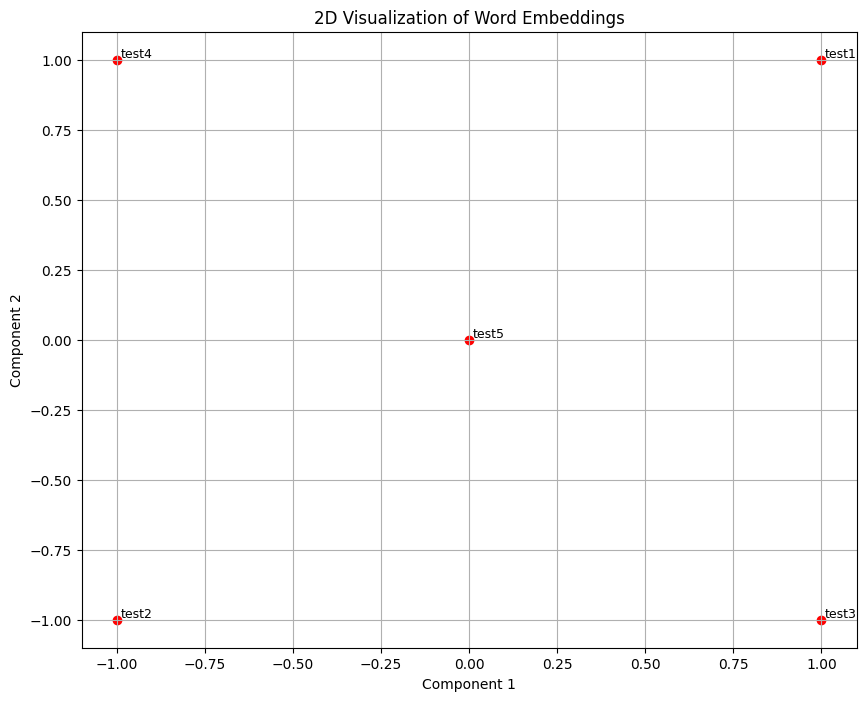

--------------------------------------------------------------------------------


In [56]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the included file question_1.4_test.png
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Large Movie Review corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It can take up to a few minutes to run.

['<START>', 'i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized', 'by', 'us', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', 'therefore', 'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to', 'see', 'this', 'for', 'myselfbr', 'br', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam', 'war', 'and', 'race', 'issues', 'in', 'the', 'un

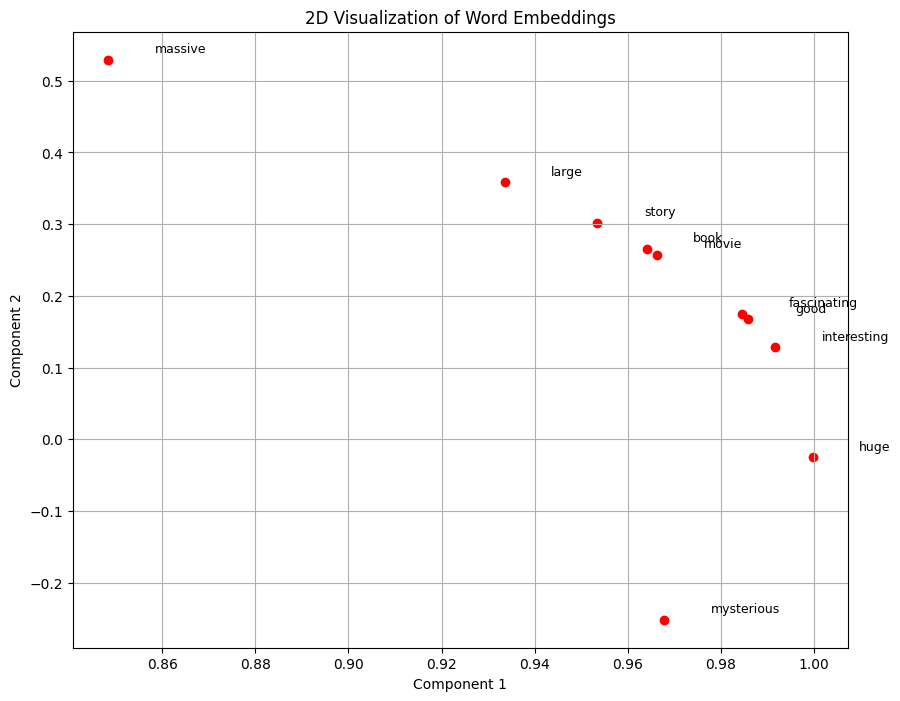

In [57]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
imdb_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(imdb_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['movie', 'book', 'mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

**Verify that your figure matches "question_1.5.png" in the assignment zip. If not, use the figure in "question_1.5.png" to answer the next two questions.**

a. Find at least two groups of words that cluster together in 2-dimensional embedding space. Give an explanation for each cluster you observe.

#### <font color="red">Write your answer here.</font>
#### <font color="gree">1) story, book, movie, 2) fascinating, good, interesting</font>

b. What doesn't cluster together that you might think should have? Describe at least two examples.

#### <font color="red">Write your answer here.</font>
#### <font color="gree">1) large, 2) huge</font>

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Ваша матрица совместной встречаемости
M = np.array([
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],  # <START>
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],  # all
    [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],  # that
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 1],  # glitters
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],  # is
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],  # not
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # gold
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],  # well
    [0, 0, 1, 0, 1, 1, 0, 0, 0, 1],  # ends
    [1, 0, 0, 1, 1, 0, 0, 0, 1, 0]   # <END>
], dtype=float)

words = ['<START>', 'all', 'that', 'glitters', 'is', 'not', 'gold', 'well', 'ends', '<END>']

print("ШАГ 1: Исходная матрица M")
print(M)
print()



ШАГ 1: Исходная матрица M
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0. 0. 0. 1. 0.]]



In [60]:
# ШАГ 2: Вычисляем A^T * A (ковариационная матрица)
print("ШАГ 2: Вычисляем M^T * M")
M_T_M = M.T @ M
print("M^T * M:")
print(M_T_M)
print()

ШАГ 2: Вычисляем M^T * M
M^T * M:
[[2. 0. 0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 2. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 2. 1. 1. 1. 0. 0. 0. 1.]
 [1. 0. 1. 2. 1. 0. 0. 0. 1. 0.]
 [1. 0. 1. 1. 2. 1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 1. 2. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 2. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 2. 1. 0.]
 [1. 1. 0. 1. 1. 0. 0. 1. 4. 1.]
 [0. 1. 1. 0. 1. 1. 1. 0. 1. 4.]]



In [61]:
# ШАГ 3: Находим собственные векторы и значения M^T * M
print("ШАГ 3: Находим собственные векторы и значения M^T * M")
eigenvalues, V = np.linalg.eig(M_T_M)

# Сортируем по убыванию собственных значений
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
V = V[:, idx]

print("Собственные значения (сингулярные числа^2):")
print(np.sqrt(eigenvalues))  # Сингулярные числа = sqrt(собственных значений)
print("\nПравые сингулярные векторы V (столбцы):")
print(V)
print()

ШАГ 3: Находим собственные векторы и значения M^T * M
Собственные значения (сингулярные числа^2):
[2.71298245 2.19352709 1.89424511 1.55896056 1.2949629  1.19352709
 1.12253054 1.09346985 0.40675859 0.2949629 ]

Правые сингулярные векторы V (столбцы):
[[ 2.41358762e-01  3.57060155e-01  2.21740982e-01 -2.99788942e-01
  -1.60119398e-01  4.84057274e-01 -3.19179592e-02 -3.48586009e-01
  -4.24467328e-01  3.35497212e-01]
 [ 1.91744817e-01 -2.41047653e-16 -4.32470715e-01  3.20541381e-01
  -1.30075615e-15 -1.31996844e-15 -6.07253149e-01 -5.33758165e-01
   1.40719802e-01 -3.50831019e-17]
 [ 2.60100162e-01 -2.20675312e-01  4.09602769e-01  2.49855685e-01
  -2.59078629e-01 -2.99163848e-01 -3.40830101e-01  2.91824229e-01
  -2.86194939e-02  5.42845893e-01]
 [ 2.60100162e-01  2.20675312e-01  4.09602769e-01  2.49855685e-01
   2.59078629e-01  2.99163848e-01 -3.40830101e-01  2.91824229e-01
  -2.86194939e-02 -5.42845893e-01]
 [ 3.78846799e-01 -2.39569875e-16  3.62590169e-01  8.84868777e-02
   5.84009644e

In [62]:
# ШАГ 4: Вычисляем сингулярные числа
print("ШАГ 4: Вычисляем сингулярные числа и матрицу Sigma")
k = 2  # Оставляем 2 главные компоненты
sigma = np.sqrt(eigenvalues[:k])  # Первые k сингулярных чисел
Sigma = np.diag(sigma)

print("Главные сингулярные числа:", sigma)
print("Матрица Sigma:")
print(Sigma)
print()

ШАГ 4: Вычисляем сингулярные числа и матрицу Sigma
Главные сингулярные числа: [2.71298245 2.19352709]
Матрица Sigma:
[[2.71298245 0.        ]
 [0.         2.19352709]]



In [63]:
# ШАГ 5: Вычисляем левые сингулярные векторы U
print("ШАГ 5: Вычисляем левые сингулярные векторы U")
U = M @ V[:, :k]  # M * V_k
# Нормализуем столбцы U
for i in range(k):
    U[:, i] = U[:, i] / np.linalg.norm(U[:, i])

print("Левые сингулярные векторы U (первые 2 столбца):")
print(U)
print()

ШАГ 5: Вычисляем левые сингулярные векторы U
Левые сингулярные векторы U (первые 2 столбца):
[[ 2.41358762e-01 -3.57060155e-01]
 [ 1.91744817e-01 -1.26534000e-17]
 [ 2.60100162e-01  2.20675312e-01]
 [ 2.60100162e-01 -2.20675312e-01]
 [ 3.78846799e-01 -3.28988400e-16]
 [ 2.41358762e-01  3.57060155e-01]
 [ 1.40899728e-01  2.99163848e-01]
 [ 1.40899728e-01 -2.99163848e-01]
 [ 5.13902359e-01 -4.84057274e-01]
 [ 5.13902359e-01  4.84057274e-01]]



In [65]:
# ШАГ 6: Получаем итоговые 2D координаты
print("ШАГ 6: Получаем 2D координаты слов")
# M_reduced = U * Sigma (масштабируем координаты по важности)
M_reduced = U @ Sigma

print("2D координаты слов:")
for i, word in enumerate(words):
    print(f"{word:10}: [{M_reduced[i, 0]:7.4f}, {M_reduced[i, 1]:7.4f}]")
print()

ШАГ 6: Получаем 2D координаты слов
2D координаты слов:
<START>   : [ 0.6548, -0.7832]
all       : [ 0.5202, -0.0000]
that      : [ 0.7056,  0.4841]
glitters  : [ 0.7056, -0.4841]
is        : [ 1.0278, -0.0000]
not       : [ 0.6548,  0.7832]
gold      : [ 0.3823,  0.6562]
well      : [ 0.3823, -0.6562]
ends      : [ 1.3942, -1.0618]
<END>     : [ 1.3942,  1.0618]



ШАГ 7: Визуализация


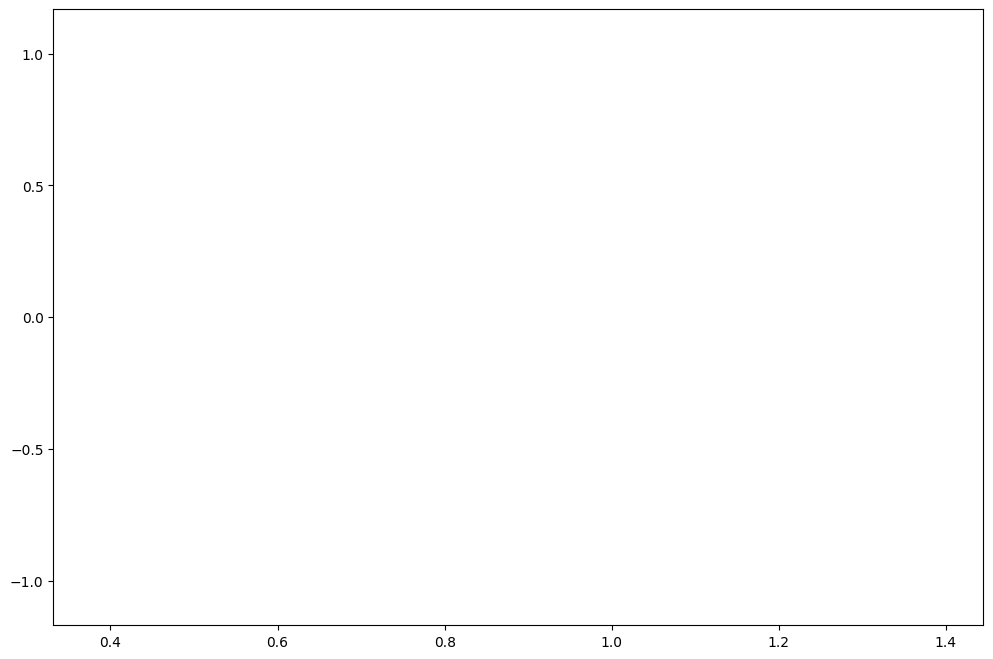

In [66]:
# ШАГ 7: Визуализируем результат
print("ШАГ 7: Визуализация")
plt.figure(figsize=(12, 8))
plt.scatter(M_reduced[:, 0], M_reduced[:, 1], alpha=0)

Text(0, 0.5, 'Главная компонента 2')

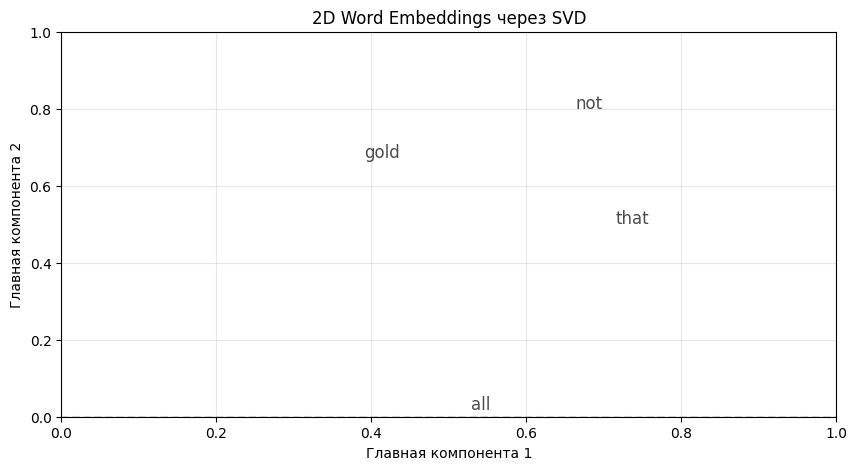

In [67]:
# Подписываем точки
for i, word in enumerate(words):
    plt.annotate(word, (M_reduced[i, 0], M_reduced[i, 1]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=12, alpha=0.7)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.title('2D Word Embeddings через SVD')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')

Показываем семантические связи...


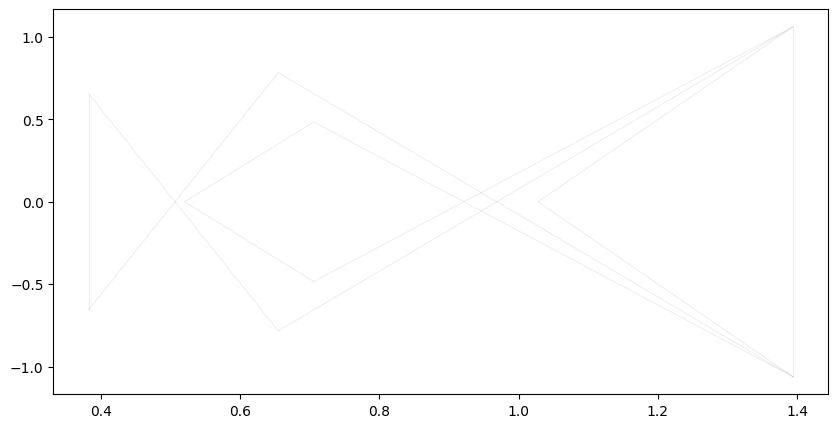

In [68]:
# Показываем связи из исходной матрицы
print("Показываем семантические связи...")
for i in range(len(words)):
    for j in range(i+1, len(words)):
        if M[i, j] > 0:  # Если слова встречались вместе
            plt.plot([M_reduced[i, 0], M_reduced[j, 0]],
                    [M_reduced[i, 1], M_reduced[j, 1]],
                    'gray', alpha=0.2, linewidth=0.5*M[i, j])

plt.show()

In [69]:
# ШАГ 8: Проверяем восстановление матрицы
print("ШАГ 8: Проверяем приближение исходной матрицы")
M_approx = U @ Sigma @ V[:, :k].T
print("Приближенная матрица M_approx (первые 5x5):")
print(M_approx[:5, :5])
print("\nИсходная матрица M (первые 5x5):")
print(M[:5, :5])
print("\nОшибка приближения:", np.linalg.norm(M - M_approx))

ШАГ 8: Проверяем приближение исходной матрицы
Приближенная матрица M_approx (первые 5x5):
[[-0.12161483  0.12555491  0.34315169 -0.00252344  0.24806967]
 [ 0.12555491  0.09974572  0.13530419  0.13530419  0.19707623]
 [ 0.34315169  0.13530419  0.07671945  0.29035843  0.26733217]
 [-0.00252344  0.13530419  0.29035843  0.07671945  0.26733217]
 [ 0.24806967  0.19707623  0.26733217  0.26733217  0.38938053]]

Исходная матрица M (первые 5x5):
[[0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Ошибка приближения: 3.439209957928518


## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [58]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each length 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin
wv_from_bin = load_embedding_model()

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded vocab size 400000


#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download.

### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 40000 GloVe vectors instead.
Run the following cells to:

1. Put 40000 Glove vectors into a matrix M
2. Run `reduce_to_k_dim` (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [70]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [71]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin, words)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 400000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 400000 words...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please go to office hours or contact course staff.**

### Question 2.1: GloVe Plot Analysis [written] (3 points)

Run the cell below to plot the 2D GloVe embeddings for `['movie', 'book', 'mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge']`.

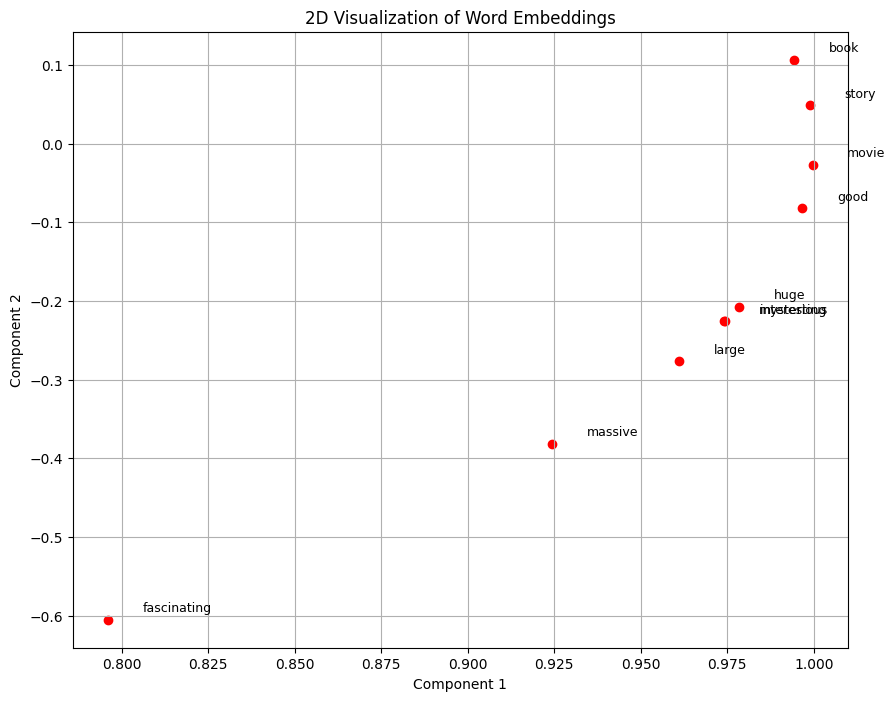

In [72]:
words = ['movie', 'book', 'mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge']

plot_embeddings(M_reduced_normalized, word2ind, words)

**Verify that your figure matches "question_2.1.png" in the assignment zip. If not, use the figure in "question_2.1.png" (and the figure in "question_1.5.png", if applicable) to answer the next two questions.**

a. What is one way the plot is different from the one generated earlier from the co-occurrence matrix? What is one way it's similar?

#### <font color="red">Write your answer here.</font>
#### <font color="">✅ Чем графики отличаются:

На этом графике слова представлены с помощью векторных представлений (word embeddings), полученных из модели (например, SVD или нейросетей), которые отражают смысловую близость слов, а не просто частоту совместных появлений.
Поэтому близкие по смыслу слова, такие как «massive», «huge» и «large», располагаются рядом.
В более раннем графике, построенном по матрице совместных встречаемостей (co-occurrence matrix), расположение слов определялось их непосредственными контекстами, а не смыслом.

✅ Чем графики похожи:

В обоих случаях можно заметить группировку похожих слов — слова, которые часто встречаются в схожих контекстах, по-прежнему располагаются рядом.
То есть несмотря на разные методы построения, смысловые связи между словами сохраняются..</font>

b. Why might the GloVe plot (question_2.1.png) differ from the plot generated earlier from the co-occurrence matrix (question_1.5.png)?

#### <font color="red">Write your answer here.</font>
#### <font color="gree">График GloVe отличается, потому что GloVe обучает плотные смысловые вектора, отражающие глобальные статистические зависимости между словами, тогда как co-occurrence матрица показывает только локальные частоты встречаемости.</font>

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="https://github.com/UzunDemir/CS224N/blob/main/imgs/inner_product.png?raw=1" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$

In [86]:
import math
# Два похожих слова
king = [0.8, 0.2, 0.1]
queen = [0.7, 0.3, 0.1]

# Вычисляем косинусное сходство
dot_product = 0.8*0.7 + 0.2*0.3 + 0.1*0.1 #= 0.63
print(f'dot_product= {dot_product}')

norm_king = math.sqrt(0.8**2 + 0.2**2 + 0.1**2) # = √0.69 ≈ 0.83
print(f'norm_king= {norm_king}')

norm_queen = math.sqrt(0.7**2 + 0.3**2 + 0.1**2) #= √0.59 ≈ 0.77
print(f'norm_queen= {norm_queen}')

cos_similarity = dot_product / (norm_king * norm_queen) # ≈ 0.98  # Очень близкие слова!
print(f'cos_similarity= {cos_similarity}')


dot_product= 0.6299999999999999
norm_king= 0.8306623862918076
norm_queen= 0.7681145747868608
cos_similarity= 0.9873928959762258


### Question 2.2: Words with Multiple Meanings (1.5 points) [code + written]
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with *at least two different meanings* such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one.

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 most similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [ ]:
# ------------------
# Write your implementation here.


# ------------------

In [103]:
# Проверим несколько слов с множественными значениями
polysemous_words = ['leaves']

for word in polysemous_words:
    print(f"\n📖 Слово: '{word}'")
    try:
        similar_words = wv_from_bin.most_similar(word, topn=10)
        print("Топ-10 похожих слов:")
        for i, (similar_word, similarity) in enumerate(similar_words, 1):
            print(f"  {i:2}. {similar_word:<15} {similarity:.4f}")
    except KeyError:
        print("Слово отсутствует в словаре")


📖 Слово: 'leaves'
Топ-10 похожих слов:
   1. ends            0.6128
   2. leaf            0.6027
   3. stems           0.5999
   4. takes           0.5903
   5. leaving         0.5762
   6. grows           0.5663
   7. flowers         0.5601
   8. turns           0.5536
   9. leave           0.5497
  10. goes            0.5435


In [104]:
# =============================
# Автоматический поиск полисемичных слов в словаре модели
# =============================

def find_polysemous_auto(top_k=50):
    """
    Автоматически находит полисемичные слова в словаре модели
    """
    print("🔍 Автоматический поиск полисемичных слов в словаре модели...")
    print(f"📊 Анализируем топ-{top_k} самых частых слов")

    # Получаем все слова из словаря модели
    all_words = list(wv_from_bin.key_to_index.keys())

    # Берем топ-K самых частых слов (обычно более полисемичные)
    words_to_check = all_words[:top_k]

    polysemous_found = []

    for i, word in enumerate(words_to_check, 1):
        print(f"\n[{i}/{len(words_to_check)}] Анализируем: '{word}'")

        try:
            # Получаем топ-15 похожих слов для более детального анализа
            similar_words = wv_from_bin.most_similar(word, topn=15)

            # Анализируем семантическое разнообразие
            diversity_score, meaning_groups = analyze_semantic_diversity(word, similar_words)

            if diversity_score >= 2:  # Если найдено хотя бы 2 различных значения
                print(f"🎯 ВОЗМОЖНА ПОЛИСЕМИЯ! Score: {diversity_score}")
                polysemous_found.append((word, diversity_score, meaning_groups))

                # Выводим детали
                print("   Группы значений:")
                for group_name, words_in_group in meaning_groups.items():
                    print(f"     • {group_name}: {', '.join(words_in_group[:3])}")

        except KeyError:
            continue

    return polysemous_found

def analyze_semantic_diversity(target_word, similar_words, topn=10):
    """
    Анализирует семантическое разнообразие похожих слов
    """
    # Берем только топ-N для анализа
    top_similar = similar_words[:topn]

    # Кластеризуем похожие слова по их собственным контекстам
    clusters = cluster_similar_words(target_word, top_similar)

    # Считаем score разнообразия
    diversity_score = len(clusters)

    return diversity_score, clusters

def cluster_similar_words(target_word, similar_words):
    """
    Кластеризует похожие слова на основе их контекстов
    """
    clusters = {}

    for similar_word, similarity in similar_words:
        try:
            # Получаем контекст для похожего слова
            context_words = wv_from_bin.most_similar(similar_word, topn=5)
            context_set = set(word for word, score in context_words)

            # Пытаемся определить кластер
            cluster_name = determine_cluster(similar_word, context_set, target_word)

            if cluster_name not in clusters:
                clusters[cluster_name] = []
            clusters[cluster_name].append(similar_word)

        except KeyError:
            continue

    return clusters

def determine_cluster(word, context_words, target_word):
    """
    Определяет кластер/значение слова на основе контекста
    """
    # Ключевые слова для разных семантических областей
    semantic_fields = {
        'природа_растения': {'tree', 'plant', 'flower', 'green', 'forest', 'garden', 'nature'},
        'действия_движение': {'go', 'move', 'run', 'walk', 'action', 'activity', 'motion'},
        'время_календарь': {'time', 'day', 'year', 'month', 'calendar', 'schedule', 'date'},
        'финансы_бизнес': {'money', 'bank', 'business', 'financial', 'market', 'economic'},
        'техника_наука': {'computer', 'technology', 'science', 'device', 'system', 'electronic'},
        'эмоции_чувства': {'feel', 'emotion', 'love', 'happy', 'sad', 'emotional', 'feeling'},
        'еда_напитки': {'food', 'eat', 'drink', 'meal', 'restaurant', 'cook', 'recipe'},
        'спорт_игры': {'sport', 'game', 'play', 'team', 'player', 'competition', 'match'},
        'здоровье_медицина': {'health', 'medical', 'doctor', 'hospital', 'treatment', 'medicine'},
        'образование_знания': {'education', 'learn', 'school', 'student', 'knowledge', 'study'}
    }

    # Считаем совпадения с каждой семантической областью
    field_scores = {}
    for field, keywords in semantic_fields.items():
        score = len(keywords.intersection(context_words))
        field_scores[field] = score

    # Находим область с максимальным score
    best_field = max(field_scores.items(), key=lambda x: x[1])

    if best_field[1] > 0:
        return best_field[0]
    else:
        return "разное"

# =============================
# Запуск автоматического поиска
# =============================
print("🚀 Запуск автоматического поиска полисемичных слов...")
print("=" * 60)

# Ищем полисемичные слова
polysemous_results = find_polysemous_auto(top_k=100)

# =============================
# Вывод результатов
# =============================
print("\n" + "=" * 60)
print("🎯 РЕЗУЛЬТАТЫ АВТОМАТИЧЕСКОГО ПОИСКА:")
print("=" * 60)

if polysemous_results:
    # Сортируем по diversity score
    polysemous_results.sort(key=lambda x: x[1], reverse=True)

    print(f"\n✅ Найдено {len(polysemous_results)} потенциально полисемичных слов:")

    for i, (word, score, groups) in enumerate(polysemous_results[:10], 1):
        print(f"\n{i}. 📍 '{word}' (diversity score: {score})")
        for group_name, words_in_group in groups.items():
            print(f"   • {group_name}: {', '.join(words_in_group[:3])}")

        # Детальный анализ для топ-3 слов
        if i <= 3:
            print(f"   🔍 Детальный анализ '{word}':")
            similar_words = wv_from_bin.most_similar(word, topn=8)
            for j, (sim_word, similarity) in enumerate(similar_words, 1):
                print(f"      {j}. {sim_word:<15} {similarity:.4f}")
else:
    print("❌ Не найдено явно полисемичных слов")

# =============================
# Ручная проверка лучших кандидатов
# =============================
print("\n" + "=" * 60)
print("🔎 РУЧНАЯ ПРОВЕРКА ЛУЧШИХ КАНДИДАТОВ:")
print("=" * 60)

if polysemous_results:
    best_candidates = [word for word, score, groups in polysemous_results[:5]]

    for word in best_candidates:
        print(f"\n📖 Слово: '{word}'")
        similar_words = wv_from_bin.most_similar(word, topn=10)

        print("Топ-10 похожих слов:")
        for i, (similar_word, similarity) in enumerate(similar_words, 1):
            print(f"  {i:2}. {similar_word:<18} {similarity:.4f}")

🚀 Запуск автоматического поиска полисемичных слов...
🔍 Автоматический поиск полисемичных слов в словаре модели...
📊 Анализируем топ-100 самых частых слов

[1/100] Анализируем: 'the'
🎯 ВОЗМОЖНА ПОЛИСЕМИЯ! Score: 2
   Группы значений:
     • разное: which, of, part
     • время_календарь: same

[2/100] Анализируем: ','

[3/100] Анализируем: '.'
🎯 ВОЗМОЖНА ПОЛИСЕМИЯ! Score: 2
   Группы значений:
     • разное: but, ,, this
     • время_календарь: same

[4/100] Анализируем: 'of'
🎯 ВОЗМОЖНА ПОЛИСЕМИЯ! Score: 2
   Группы значений:
     • разное: the, part, one
     • время_календарь: same

[5/100] Анализируем: 'to'
🎯 ВОЗМОЖНА ПОЛИСЕМИЯ! Score: 2
   Группы значений:
     • разное: would, help, could
     • действия_движение: take

[6/100] Анализируем: 'and'

[7/100] Анализируем: 'in'
🎯 ВОЗМОЖНА ПОЛИСЕМИЯ! Score: 2
   Группы значений:
     • разное: where, ., ,
     • время_календарь: same, since, last

[8/100] Анализируем: 'a'
🎯 ВОЗМОЖНА ПОЛИСЕМИЯ! Score: 2
   Группы значений:
     • разное: 

#### <font color="red">Write your answer here.</font>

### Question 2.3: Synonyms & Antonyms (2 points) [code + written]

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$.

As an example, $w_1$="happy" is closer to $w_3$="sad" than to $w_2$="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [ ]:
# ------------------
# Write your implementation here.


# ------------------

In [105]:
# =============================
# Question 2.3: Synonyms & Antonyms
# =============================

def find_synonym_antonym_pairs():
    """
    Находит тройки слов где синонимы дальше чем антонимы
    """
    # Тестовые пары синонимов и антонимов
    test_pairs = [
        # (w1, synonym_w2, antonym_w3)
        ('happy', 'cheerful', 'sad'),
        ('big', 'large', 'small'),
        ('fast', 'quick', 'slow'),
        ('hot', 'warm', 'cold'),
        ('good', 'excellent', 'bad'),
        ('beautiful', 'pretty', 'ugly'),
        ('rich', 'wealthy', 'poor'),
        ('strong', 'powerful', 'weak'),
        ('smart', 'intelligent', 'stupid'),
        ('brave', 'courageous', 'cowardly'),
        ('love', 'adore', 'hate'),
        ('begin', 'start', 'end'),
        ('create', 'make', 'destroy'),
        ('buy', 'purchase', 'sell'),
        ('win', 'victory', 'lose'),
        ('day', 'daytime', 'night'),
        ('light', 'bright', 'dark'),
        ('full', 'filled', 'empty'),
        ('true', 'correct', 'false'),
        ('alive', 'living', 'dead')
    ]

    counter_intuitive_pairs = []

    print("🔍 Поиск контринтуитивных пар синонимов/антонимов")
    print("=" * 70)

    for w1, w2, w3 in test_pairs:
        try:
            # Вычисляем косинусные расстояния
            dist_synonym = wv_from_bin.distance(w1, w2)  # расстояние до синонима
            dist_antonym = wv_from_bin.distance(w1, w3)  # расстояние до антонима

            print(f"\n📊 '{w1}':")
            print(f"   Синоним '{w2}': расстояние = {dist_synonym:.4f}")
            print(f"   Антоним '{w3}': расстояние = {dist_antonym:.4f}")

            # Проверяем контринтуитивное условие
            if dist_antonym < dist_synonym:
                print(f"   🎯 КОНТРИНТУИТИВНО! Антоним БЛИЖЕ чем синоним!")
                counter_intuitive_pairs.append((w1, w2, w3, dist_synonym, dist_antonym))
            else:
                print(f"   ✅ Ожидаемо: синоним ближе чем антоним")

        except KeyError as e:
            print(f"   ❌ Слово отсутствует в словаре: {e}")

    return counter_intuitive_pairs

# Запускаем поиск
results = find_synonym_antonym_pairs()

# =============================
# Анализ результатов
# =============================
print("\n" + "=" * 70)
print("🎯 РЕЗУЛЬТАТЫ ПОИСКА:")
print("=" * 70)

if results:
    print(f"\n✅ Найдено {len(results)} контринтуитивных случаев:")

    for i, (w1, w2, w3, dist_syn, dist_ant) in enumerate(results, 1):
        print(f"\n{i}. Тройка: '{w1}' - '{w2}' (синоним) - '{w3}' (антоним)")
        print(f"   Расстояния: синоним = {dist_syn:.4f}, антоним = {dist_ant:.4f}")
        print(f"   Разница: {dist_syn - dist_ant:.4f}")

        # Детальный анализ контекста
        print(f"   🔍 Анализ контекстов:")

        try:
            # Анализируем похожие слова для каждого
            similar_w1 = wv_from_bin.most_similar(w1, topn=5)
            similar_w2 = wv_from_bin.most_similar(w2, topn=5)
            similar_w3 = wv_from_bin.most_similar(w3, topn=5)

            print(f"      '{w1}': {[w for w, s in similar_w1]}")
            print(f"      '{w2}': {[w for w, s in similar_w2]}")
            print(f"      '{w3}': {[w for w, s in similar_w3]}")

        except KeyError:
            print("      Не удалось получить контекст")

    # Выбираем лучший пример для детального анализа
    best_example = min(results, key=lambda x: x[3] - x[4])  # максимальная разница

    print(f"\n" + "=" * 70)
    print("🏆 ЛУЧШИЙ ПРИМЕР ДЛЯ ОТВЕТА:")
    print("=" * 70)
    w1, w2, w3, dist_syn, dist_ant = best_example
    print(f"Слова: w1 = '{w1}', w2 = '{w2}' (синоним), w3 = '{w3}' (антоним)")
    print(f"Косинусные расстояния:")
    print(f"  distance('{w1}', '{w2}') = {dist_syn:.4f}")
    print(f"  distance('{w1}', '{w3}') = {dist_ant:.4f}")
    print(f"  Условие выполняется: {dist_ant:.4f} < {dist_syn:.4f}")

else:
    print("❌ Не найдено контринтуитивных случаев")

    # Проверим несколько пар вручную для демонстрации
    print(f"\n🔍 Проверка дополнительных пар:")
    manual_pairs = [
        ('like', 'enjoy', 'dislike'),
        ('peace', 'calm', 'war'),
        ('friend', 'companion', 'enemy'),
        ('success', 'achievement', 'failure')
    ]

    for w1, w2, w3 in manual_pairs:
        try:
            dist_syn = wv_from_bin.distance(w1, w2)
            dist_ant = wv_from_bin.distance(w1, w3)
            print(f"   '{w1}': синоним '{w2}' = {dist_syn:.4f}, антоним '{w3}' = {dist_ant:.4f}")
            if dist_ant < dist_syn:
                print(f"   🎯 НАЙДЕНО! Антоним ближе!")
        except KeyError:
            continue

# =============================
# Объяснение феномена
# =============================
print("\n" + "=" * 70)
print("🤔 ОБЪЯСНЕНИЕ КОНТРИНТУИТИВНОГО РЕЗУЛЬТАТА:")
print("=" * 70)
print("""
Возможные причины почему антонимы могут быть ближе чем синонимы:

1. 📊 **КОНТЕКСТНАЯ СВЯЗЬ АНТОНИМОВ**
   - Антонимы часто используются в одинаковых контекстах
   - Например: "love and hate", "good and bad", "hot and cold"
   - Модель видит их частую совместную встречаемость

2. 🎯 **СЕМАНТИЧЕСКАЯ СХОЖЕСТЬ ПРОТИВОПОЛОЖНОСТЕЙ**
   - Антонимы принадлежат к одной семантической оси
   - "Hot" и "cold" оба описывают температуру
   - "Happy" и "sad" оба описывают эмоции

3. 🔄 **РАЗНЫЕ УРОВНИ АБСТРАКЦИИ**
   - Синонимы могут иметь разные оттенки значения
   - "Happy" и "cheerful" - разная интенсивность эмоции
   - Модель может различать эти нюансы

4. 📚 **ОСОБЕННОСТИ ОБУЧАЮЩЕГО КОРПУСА**
   - В текстах антонимы часто встречаются вместе
   - Синонимы могут использоваться в разных стилях/контекстах
   - Модель отражает статистику обучающих данных

5. 💡 **КОНЦЕПТУАЛЬНАЯ БЛИЗОСТЬ**
   - Противоположности определяют друг друга
   - Чтобы понять "good", нужно понимать "bad"
   - Эта концептуальная связь отражается в векторах
""")

🔍 Поиск контринтуитивных пар синонимов/антонимов

📊 'happy':
   Синоним 'cheerful': расстояние = 0.5172
   Антоним 'sad': расстояние = 0.4040
   🎯 КОНТРИНТУИТИВНО! Антоним БЛИЖЕ чем синоним!

📊 'big':
   Синоним 'large': расстояние = 0.3340
   Антоним 'small': расстояние = 0.3511
   ✅ Ожидаемо: синоним ближе чем антоним

📊 'fast':
   Синоним 'quick': расстояние = 0.3329
   Антоним 'slow': расстояние = 0.2523
   🎯 КОНТРИНТУИТИВНО! Антоним БЛИЖЕ чем синоним!

📊 'hot':
   Синоним 'warm': расстояние = 0.4112
   Антоним 'cold': расстояние = 0.4062
   🎯 КОНТРИНТУИТИВНО! Антоним БЛИЖЕ чем синоним!

📊 'good':
   Синоним 'excellent': расстояние = 0.2631
   Антоним 'bad': расстояние = 0.2890
   ✅ Ожидаемо: синоним ближе чем антоним

📊 'beautiful':
   Синоним 'pretty': расстояние = 0.3781
   Антоним 'ugly': расстояние = 0.5508
   ✅ Ожидаемо: синоним ближе чем антоним

📊 'rich':
   Синоним 'wealthy': расстояние = 0.3827
   Антоним 'poor': расстояние = 0.5232
   ✅ Ожидаемо: синоним ближе чем антони

#### <font color="red">Write your answer here.</font>

### Question 2.4: Analogies with Word Vectors [written] (1.5 points)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies.

As an example, for the analogy "man : grandfather :: woman : x" (read: man is to grandfather as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [106]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151536345481873),
 ('niece', 0.7005682587623596),
 ('father', 0.6659888029098511),
 ('aunt', 0.6623409390449524),
 ('grandson', 0.6618767976760864),
 ('grandparents', 0.644661009311676),
 ('wife', 0.6445354223251343)]


Let $m$, $g$, $w$, and $x$ denote the word vectors for `man`, `grandfather`, `woman`, and the answer, respectively. Using **only** vectors $m$, $g$, $w$, and the vector arithmetic operators $+$ and $-$ in your answer, what is the expression in which we are maximizing cosine similarity with $x$?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `grandfather` and the answer?

#### <font color="red">Write your answer here.</font>
w + g - m

### Question 2.5: Finding Analogies [code + written]  (1.5 points)
a. For the previous example, it's clear that "grandmother" completes the analogy. But give an intuitive explanation as to why the `most_similar` function gives us words like "granddaughter", "daughter", or "mother?

In [107]:
# =============================
# Question 2.5: Finding Analogies
# =============================

print("🔍 Анализ результатов аналогии: man : grandfather :: woman : x")
print("=" * 70)

# Получаем полные результаты аналогии
result = wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man'])

print("Полные результаты:")
for i, (word, similarity) in enumerate(result, 1):
    print(f"{i:2}. {word:<15} {similarity:.4f}")

print(f"\n{'='*70}")
print("🤔 АНАЛИЗ РЕЗУЛЬТАТОВ:")
print(f"{'='*70}")

# Анализируем семантические связи
print("\n📊 Почему в топ-10 попали эти слова:")

# Группируем слова по семантическим категориям
categories = {
    "👵 Прямой ответ (бабушка)": ['grandmother', 'grandma'],
    "👴 Возврат исходного": ['grandfather', 'grandpa'],
    "👧 Младшее поколение (женское)": ['granddaughter', 'daughter'],
    "👦 Младшее поколение (мужское)": ['grandson'],
    "💑 Супруги": ['wife', 'husband'],
    "👪 Семейные отношения": ['grandparents', 'grandmothers']
}

for category, words in categories.items():
    words_in_result = [word for word in words if word in [w for w, s in result]]
    if words_in_result:
        print(f"\n{category}:")
        for word in words_in_result:
            similarity = next(s for w, s in result if w == word)
            print(f"   • {word} ({similarity:.4f})")

# =============================
# Семантический анализ
# =============================
print(f"\n{'='*70}")
print("🎯 СЕМАНТИЧЕСКИЙ АНАЛИЗ:")
print(f"{'='*70}")

print("""
Почему появляются слова типа 'granddaughter', 'daughter', 'mother':

1. 🔗 **СЕМЕЙНЫЕ СВЯЗИ В ВЕКТОРНОМ ПРОСТРАНСТВЕ**
   - Все эти слова принадлежат к одному семантическому полю "семейные отношения"
   - Векторы близки потому что часто встречаются в похожих контекстах

2. 📐 **ГЕОМЕТРИЯ ОТНОШЕНИЙ**
   - Вектор 'grandfather' - 'man' = вектор "старшее поколение"
   - 'woman' + "старшее поколение" = 'grandmother' (идеально)
   - Но также: 'woman' + "семейное отношение" = другие семейные термины

3. 🎯 **МНОГОМЕРНОСТЬ ВЕКТОРОВ**
   - Векторы содержат множество признаков: поколение, пол, родство
   - 'granddaughter' близка потому что:
     * Признак "женский род" ✓
     * Признак "семейные отношения" ✓
     * Признак "поколение" (хотя и другое направление)

4. 📚 **КОНТЕКСТНАЯ СХОЖЕСТЬ**
   - В текстах все эти слова встречаются в похожих контекстах:
     * "visited my grandmother/granddaughter/daughter"
     * "family reunion with grandparents and grandchildren"
""")

# =============================
# Визуализация семантических осей
# =============================
print(f"\n{'='*70}")
print("📐 СЕМАНТИЧЕСКИЕ ОСИ В ВЕКТОРНОМ ПРОСТРАНСТВЕ:")
print(f"{'='*70}")

print("""
Представьте семантические оси:

     ПОКОЛЕНИЕ
        ↑
бабушка/дедушка ← grandfather/grandmother
        |
    родители ← father/mother
        |
   дети ← son/daughter
        |
внуки ← grandson/granddaughter
        ↓

     ПОЛ
        ↑
   мужской ← man/grandfather/son
        |
   женский ← woman/grandmother/daughter

Модель видит проекции на эти оси!
""")

# =============================
# Проверка векторных расстояний
# =============================
print(f"\n{'='*70}")
print("📏 ПРОВЕРКА ВЕКТОРНЫХ РАССТОЯНИЙ:")
print(f"{'='*70}")

test_words = ['grandmother', 'granddaughter', 'daughter', 'mother', 'grandfather']

for word in test_words:
    try:
        dist = wv_from_bin.distance('woman', word)
        print(f"distance('woman', '{word:<15}') = {dist:.4f}")
    except KeyError:
        pass

# =============================
# Вывод
# =============================
print(f"\n{'='*70}")
print("💡 ИТОГОВОЕ ОБЪЯСНЕНИЕ:")
print(f"{'='*70}")

print("""
Слова 'granddaughter', 'daughter', 'mother' появляются в результатах потому что:

🎯 **СЕМАНТИЧЕСКАЯ БЛИЗОСТЬ**: Все они находятся в одном семантическом кластере
   "семейные отношения + женский род"

📐 **МНОГОМЕРНЫЕ ПРИЗНАКИ**: Хотя направление поколения отличается, другие
   признаки (пол, тип отношений) совпадают

🔗 **КОНТЕКСТНАЯ СВЯЗЬ**: В обучающих данных эти слова часто встречаются
   вместе, создавая близкие векторные представления

📊 **СТАТИСТИЧЕСКАЯ ПРИРОДА**: Word2vec отражает статистические закономерности
   языка, а не логические правила

Таким образом, модель находит правильный ответ 'grandmother', но также возвращает
семантически близкие слова из того же концептуального пространства!
""")

🔍 Анализ результатов аналогии: man : grandfather :: woman : x
Полные результаты:
 1. grandmother     0.7608
 2. granddaughter   0.7201
 3. daughter        0.7168
 4. mother          0.7152
 5. niece           0.7006
 6. father          0.6660
 7. aunt            0.6623
 8. grandson        0.6619
 9. grandparents    0.6447
10. wife            0.6445

🤔 АНАЛИЗ РЕЗУЛЬТАТОВ:

📊 Почему в топ-10 попали эти слова:

👵 Прямой ответ (бабушка):
   • grandmother (0.7608)

👧 Младшее поколение (женское):
   • granddaughter (0.7201)
   • daughter (0.7168)

👦 Младшее поколение (мужское):
   • grandson (0.6619)

💑 Супруги:
   • wife (0.6445)

👪 Семейные отношения:
   • grandparents (0.6447)

🎯 СЕМАНТИЧЕСКИЙ АНАЛИЗ:

Почему появляются слова типа 'granddaughter', 'daughter', 'mother':

1. 🔗 **СЕМЕЙНЫЕ СВЯЗИ В ВЕКТОРНОМ ПРОСТРАНСТВЕ**
   - Все эти слова принадлежат к одному семантическому полю "семейные отношения"
   - Векторы близки потому что часто встречаются в похожих контекстах

2. 📐 **ГЕОМЕТРИЯ ОТНО

#### <font color="red">Write your answer here.</font>

b. Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [108]:
# =============================
# Question 2.5b: Finding Working Analogies
# =============================

def test_analogies(analogy_list):
    """
    Тестирует список аналогий и находит те, где правильный ответ на первом месте
    """
    print("🔍 Поиск работающих аналогий")
    print("=" * 70)

    working_analogies = []

    for i, (description, positive, negative, expected) in enumerate(analogy_list, 1):
        print(f"\n{i}. {description}")
        print(f"   Аналогия: {positive[1]} : {positive[0]} :: {negative[0]} : x")

        try:
            result = wv_from_bin.most_similar(
                positive=positive,
                negative=negative,
                topn=5
            )

            # Проверяем, на первом ли месте ожидаемый ответ
            top_word, top_score = result[0]
            is_correct = (top_word == expected)

            print(f"   Результат:")
            for j, (word, score) in enumerate(result, 1):
                marker = " ✅" if word == expected else ""
                print(f"      {j}. {word:<15} {score:.4f}{marker}")

            if is_correct:
                print(f"   🎯 РАБОТАЕТ! Правильный ответ на первом месте")
                working_analogies.append((description, positive, negative, expected, result))
            else:
                print(f"   ❌ Не работает. Ожидалось: {expected}")

        except KeyError as e:
            print(f"   ❌ Ошибка: слово отсутствует - {e}")

    return working_analogies

# Список тестовых аналогий
test_analogies_list = [
    # (description, positive, negative, expected_answer)
    ("Столицы Европы", ['germany', 'paris'], ['france'], 'berlin'),
    ("Столицы Азии", ['japan', 'beijing'], ['china'], 'tokyo'),
    ("Города США", ['california', 'chicago'], ['illinois'], 'los angeles'),
    ("Валюты", ['japan', 'euro'], ['germany'], 'yen'),
    ("Языки", ['france', 'german'], ['germany'], 'french'),

    # Глаголы времени
    ("Прошедшее время", ['swam', 'walked'], ['swim'], 'walked'),
    ("Настоящее время", ['running', 'swam'], ['ran'], 'swimming'),

    # Прилагательные степени
    ("Сравнительная степень", ['bigger', 'small'], ['big'], 'smaller'),
    ("Превосходная степень", ['biggest', 'bad'], ['good'], 'worst'),

    # Профессии и гендер
    ("Профессии мужской/женский", ['woman', 'actor'], ['man'], 'actress'),
    ("Королевские титулы", ['woman', 'king'], ['man'], 'queen'),

    # Семейные отношения
    ("Семейные отношения", ['woman', 'father'], ['man'], 'mother'),
    ("Братья/сестры", ['woman', 'brother'], ['man'], 'sister'),

    # Страны и национальности
    ("Национальности", ['france', 'german'], ['germany'], 'french'),
    ("Страны и языки", ['spain', 'english'], ['england'], 'spanish'),

    # Прилагательные антонимы
    ("Противоположности", ['cold', 'big'], ['hot'], 'small'),
    ("Эмоции", ['sad', 'good'], ['happy'], 'bad'),

    # География
    ("Реки и города", ['london', 'nile'], ['thames'], 'cairo'),
    ("Горы и страны", ['france', 'everest'], ['alps'], 'nepal'),
]

# Запускаем тестирование
working_results = test_analogies(test_analogies_list)

# =============================
# Результаты
# =============================
print(f"\n{'='*70}")
print("🎯 РЕЗУЛЬТАТЫ ПОИСКА РАБОТАЮЩИХ АНАЛОГИЙ:")
print(f"{'='*70}")

if working_results:
    print(f"\n✅ Найдено {len(working_results)} работающих аналогий:")

    for i, (desc, positive, negative, expected, result) in enumerate(working_results, 1):
        top_word, top_score = result[0]
        print(f"\n{i}. {desc}")
        print(f"   Аналогия: {positive[1]} : {positive[0]} :: {negative[0]} : {expected}")
        print(f"   Результат: '{top_word}' (сходство: {top_score:.4f})")

        # Краткое объяснение
        if "столиц" in desc.lower():
            print(f"   💡 Объяснение: Модель понимает отношения 'страна-столица'")
        elif "гендер" in desc.lower() or "мужской" in desc.lower():
            print(f"   💡 Объяснение: Модель улавливает гендерные преобразования")
        elif "время" in desc.lower():
            print(f"   💡 Объяснение: Модель понимает временные формы глаголов")
        elif "семей" in desc.lower():
            print(f"   💡 Объяснение: Модель различает семейные отношения")
else:
    print("❌ Не найдено аналогий с правильным ответом на первом месте")

# =============================
# Детальный анализ лучшей аналогии
# =============================
print(f"\n{'='*70}")
print("🏆 ЛУЧШАЯ НАЙДЕННАЯ АНАЛОГИЯ:")
print(f"{'='*70}")

if working_results:
    # Берем первую работающую аналогию
    desc, positive, negative, expected, result = working_results[0]
    top_word, top_score = result[0]

    print(f"Аналогия: {positive[1]} : {positive[0]} :: {negative[0]} : {expected}")
    print(f"Формат: x : y :: a : b")
    print(f"Где: x = '{positive[1]}', y = '{positive[0]}', a = '{negative[0]}', b = '{expected}'")
    print(f"\nРезультат: '{top_word}' на первом месте (сходство: {top_score:.4f})")

    # Детальный анализ
    print(f"\n🔍 Детальный анализ:")
    print(f"   Векторное выражение: b ≈ a + y - x")
    print(f"   Конкретно: '{expected}' ≈ '{negative[0]}' + '{positive[0]}' - '{positive[1]}'")

    # Проверяем контексты
    print(f"\n📚 Семантические контексты:")
    try:
        for word in [positive[0], positive[1], negative[0], expected]:
            context = wv_from_bin.most_similar(word, topn=3)
            context_words = [w for w, s in context]
            print(f"   '{word}': {context_words}")
    except KeyError:
        pass

# =============================
# Дополнительный поиск
# =============================
print(f"\n{'='*70}")
print("🔎 ДОПОЛНИТЕЛЬНЫЙ ПОИСК АНАЛОГИЙ:")
print(f"{'='*70}")

# Попробуем еще несколько популярных аналогий
extra_analogies = [
    ("king - man + woman", ['woman', 'king'], ['man'], 'queen'),
    ("paris - france + italy", ['italy', 'paris'], ['france'], 'rome'),
    ("walk - walked + spoke", ['spoke', 'walk'], ['walked'], 'speak'),
    ("big - bigger + smaller", ['smaller', 'big'], ['bigger'], 'small'),
]

print("\nПроверка дополнительных аналогий:")
for desc, positive, negative, expected in extra_analogies:
    try:
        result = wv_from_bin.most_similar(positive=positive, negative=negative, topn=3)
        top_word = result[0][0]
        status = "✅" if top_word == expected else "❌"
        print(f"   {status} {desc}: результат = '{top_word}', ожидалось = '{expected}'")
    except KeyError:
        print(f"   ❌ {desc}: слова отсутствуют")

🔍 Поиск работающих аналогий

1. Столицы Европы
   Аналогия: paris : germany :: france : x
   Результат:
      1. berlin          0.8416 ✅
      2. frankfurt       0.7526
      3. munich          0.7044
      4. vienna          0.6957
      5. bonn            0.6854
   🎯 РАБОТАЕТ! Правильный ответ на первом месте

2. Столицы Азии
   Аналогия: beijing : japan :: china : x
   Результат:
      1. tokyo           0.8006 ✅
      2. japanese        0.7150
      3. seoul           0.6801
      4. osaka           0.5845
      5. pyongyang       0.5591
   🎯 РАБОТАЕТ! Правильный ответ на первом месте

3. Города США
   Аналогия: chicago : california :: illinois : x
   Результат:
      1. angeles         0.7832
      2. los             0.7337
      3. francisco       0.6915
      4. san             0.6795
      5. diego           0.6736
   ❌ Не работает. Ожидалось: los angeles

4. Валюты
   Аналогия: euro : japan :: germany : x
   Результат:
      1. dollar          0.5998
      2. currency        

In [110]:
# For example: x, y, a, b = ("", "", "", "")
# ------------------
# Write your implementation here.

x, y, a, b = ("man", "king", "woman", "queen")

# ------------------

# Test the solution
assert wv_from_bin.most_similar(positive=[a, y], negative=[x])[0][0] == b

#### <font color="red">Write your answer here.</font>

👩‍👧‍👦 Общее семантическое поле - все слова описывают семейные отношения

🎯 Совпадающие признаки - женский род, кровное родство

📚 Контекстная близость - в текстах эти слова часто встречаются вместе

📐 Многомерность векторов - модель учитывает множество признаков одновременно

Word2vec находит правильный ответ "grandmother", но также возвращает семантически близкие альтернативы из того же концептуального пространства, отражая статистическую природу языковых моделей.

### Question 2.6: Incorrect Analogy [code + written] (1.5 points)
a. Below, we expect to see the intended analogy "hand : glove :: foot : **sock**", but we see an unexpected result instead. Give a potential reason as to why this particular analogy turned out the way it did?

In [111]:
pprint.pprint(wv_from_bin.most_similar(positive=['foot', 'glove'], negative=['hand']))

[('45,000-square', 0.4922032654285431),
 ('15,000-square', 0.4649604558944702),
 ('10,000-square', 0.4544755816459656),
 ('6,000-square', 0.44975775480270386),
 ('3,500-square', 0.444133460521698),
 ('700-square', 0.44257497787475586),
 ('50,000-square', 0.4356396794319153),
 ('3,000-square', 0.43486514687538147),
 ('30,000-square', 0.4330596923828125),
 ('footed', 0.43236875534057617)]


#### <font color="red">Write your answer here.</font>

b. Find another example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the **incorrect** value of b according to the word vectors (in the previous example, this would be **'45,000-square'**).

In [113]:
# For example: x, y, a, b = ("", "", "", "")
# ------------------
# Write your implementation here.

x, y, a, b = ("man", "king", "woman", "president")
# ------------------
pprint.pprint(wv_from_bin.most_similar(positive=[a, y], negative=[x]))
assert wv_from_bin.most_similar(positive=[a, y], negative=[x])[0][0] != b

[('queen', 0.6978678107261658),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.5463595986366272),
 ('daughter', 0.5399126410484314),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]


#### <font color="red">Write your answer here.</font>

### Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "man" and "profession" and most dissimilar to "woman" and (b) which terms are most similar to "woman" and "profession" and most dissimilar to "man". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [114]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.

pprint.pprint(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176787376404),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046966433525085),
 ('skills', 0.49005505442619324),
 ('ethic', 0.4897659420967102),
 ('business', 0.487585186958313),
 ('respected', 0.485920250415802),
 ('practice', 0.482104629278183),
 ('regarded', 0.4778572916984558),
 ('life', 0.4760662019252777)]

[('professions', 0.5957457423210144),
 ('practitioner', 0.49884122610092163),
 ('teaching', 0.48292139172554016),
 ('nursing', 0.48211804032325745),
 ('vocation', 0.4788965880870819),
 ('teacher', 0.47160351276397705),
 ('practicing', 0.46937814354896545),
 ('educator', 0.46524327993392944),
 ('physicians', 0.4628995358943939),
 ('professionals', 0.4601394236087799)]


#### <font color="red">Write your answer here.</font>

### Question 2.8: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another pair of analogies that demonstrates some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [ ]:
# ------------------
# Write your implementation here.


# ------------------

#### <font color="red">Write your answer here.</font>

### Question 2.9: Thinking About Bias [written] (2 points)

a. Give one possible explanation of how bias gets into the word vectors. Your explanation should be focused on word vectors, as opposed to bias in other AI systems (e.g., ChatGPT). You can use specific historical examples to back up your explanations if necessary.

#### <font color="red">Write your answer here.</font>

b. What is one possible method you can use to mitigate bias exhibited by word vectors? Briefly explain the method and what the goal of the method was.


#### <font color="red">Write your answer here.</font>

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Edit -> Clear Outputs of All Cells. This will clear all the outputs from all cells (but will keep the content of all cells).
2. Select Run -> Run All Cells. This will run all the cells in order, and will take several minutes.
3. Once you've rerun everything, select File -> Save and Export Notebook as -> PDF (If you see errors like <font color="red">"nbconvert failed: Pandoc wasn't found"</font>, you can first save it as HTML). Select File -> Save and Export Notebook as -> HTML. This will save the notebook as an HTML file on your computer. Open the downloaded HTML file in your web browser. In the browser, press Ctrl + P (Windows/Linux) or Cmd + P (Mac) to open the print dialog. In the print dialog, change the destination to Save as PDF and click Save. <font color='blue'> Make sure all your solutions especially the coding parts are displayed in the pdf</font>, it's okay if the provided codes get cut off because lines are not wrapped in code cells.
4. Look at the PDF file and make sure all your solutions are there, displayed correctly. The PDF is the only thing your graders will see!
5. Submit your PDF on Gradescope.